# Skin Disease Classification Using EfficientNet (Deep Learning)

### Description:

The **Skin Disease Classification System** is an application based on deep learning and computer vision techniques, designed to classify skin disease images. The model is built using **EfficientNet-B0**, a convolutional neural network, to accurately classify skin disease images into **20 different categories**.

The trained model can predict skin diseases from unseen images and report both the predicted class and confidence score.

### Key Features:
- Multi-class skin disease classification (20 classes)
- EfficientNet-B0 pretrained CNN architecture
- Class imbalance handling using weighted loss
- Confusion matrix and classification report analysis
- Single-image prediction with confidence score



In [1]:
!pip install opendatasets
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=13b51ee05d81462c415ef8a32627b639623777baa59b9e49013cd5be46123ee7
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


# 1. Download the dataset

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/pacificrm/skindiseasedataset'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/pacificrm/skindiseasedataset


100%|██████████| 1.36G/1.36G [00:12<00:00, 117MB/s]


In [3]:
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/train/Benign_tumors
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/train/Eczema
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/test/Eczema

# 2. Import libraries

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 3. Prepare Skin Disease Image Dataset for Deep Learning

This section prepares the dataset for training a deep learning model for skin disease classification using PyTorch.  
It includes image transformations, dataset loading, and data loader creation.

In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = '/content/skindiseasedataset/SkinDisease/SkinDisease/'

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class_names = train_ds.classes
print(f"Loaded {len(train_ds)} training and {len(val_ds)} test images")
print(f"Number of classes: {len(class_names)} → {class_names}")

Loaded 11795 training and 1313 test images
Number of classes: 20 → ['Acne', 'Actinic_Keratosis', 'Bullous', 'Candidiasis', 'DrugEruption', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


# 4. Visualize Class Distribution in Training Set

This section creates a bar chart to visualize the number of images for each skin disease class in the training dataset.  

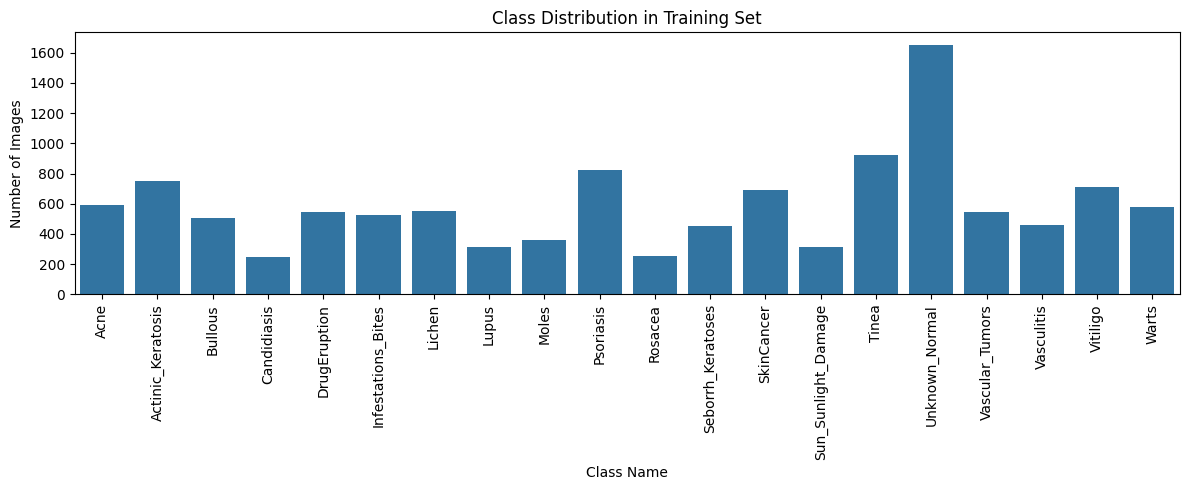

In [12]:
import seaborn as sns
from collections import Counter

# Class distribution bar chart
label_counts = Counter(train_ds.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

# 5. Compute Class Weights for Imbalance

This section calculates class weights to handle class imbalance in the dataset.

If some classes (diseases) have many more samples than others, the model may develop tendency to predict majority classes.

These class weights can be passed to the loss function during model training to improve performance on minority classes.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
labels = [label for _, label in train_ds.samples]
class_weights = compute_class_weight('balanced', classes=np.arange(len(train_ds.classes)), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.9945, 0.7884, 1.1701, 2.3780, 1.0782, 1.1255, 1.0665, 1.8963, 1.6337,
        0.7192, 2.3219, 1.2962, 0.8510, 1.8902, 0.6389, 0.3572, 1.0861, 1.2793,
        0.8260, 1.0168], device='cuda:0')


# 6. Visualize Sample Images

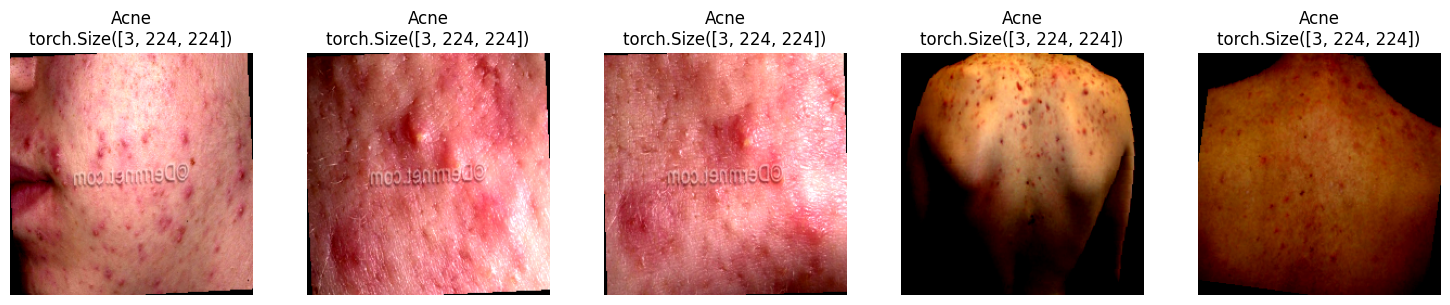

In [20]:
# Visual check of sample images (with titles and shape info)
def visualize_samples(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        image, label = dataset[i]
        img_display = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img_display)
        axes[i].set_title(f"{class_names[label]}\n{image.shape}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(train_ds)

# 7. Define Model, Loss Function, Optimizer & Scheduler
- Initialize EfficientNet-B0 model with pretrained weights for skin disease classification.

- Set up CrossEntropyLoss as loss function with class weights to handle imbalance.

- Configure AdamW optimizer for efficient gradient updates.

- Add a ReduceLROnPlateau scheduler to adjust learning rate dynamically during training.

In [21]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(train_ds.classes))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 98.3MB/s]

Loaded pretrained weights for efficientnet-b0


# 8. Implement Training Loop
This section implements the training and validation loop for the EfficientNet model, including early stopping and saving the best-performing model.


In [22]:
EPOCHS = 20
best_val_acc = 0
patience, counter = 5, 0
checkpoint_path = "best_efficientnet.pth"

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = train_correct = train_total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}  Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}  —  Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print("📌 Best model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break

# Load best weights
model.load_state_dict(torch.load(checkpoint_path))
print("✅ Training complete; best model loaded.")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20  Train loss: 2.3223, Train accuracy: 0.3535  —  Validation loss: 1.6473, Validation accuracy: 0.4989
📌 Best model saved.
Epoch 2/20  Train loss: 1.5298, Train accuracy: 0.5591  —  Validation loss: 1.2518, Validation accuracy: 0.6207
📌 Best model saved.
Epoch 3/20  Train loss: 1.1843, Train accuracy: 0.6546  —  Validation loss: 1.0684, Validation accuracy: 0.6687
📌 Best model saved.
Epoch 4/20  Train loss: 0.9621, Train accuracy: 0.7150  —  Validation loss: 0.9556, Validation accuracy: 0.6984
📌 Best model saved.
Epoch 5/20  Train loss: 0.7631, Train accuracy: 0.7708  —  Validation loss: 0.9180, Validation accuracy: 0.7113
📌 Best model saved.
Epoch 6/20  Train loss: 0.6170, Train accuracy: 0.8138  —  Validation loss: 0.8541, Validation accuracy: 0.7540
📌 Best model saved.
Epoch 7/20  Train loss: 0.5028, Train accuracy: 0.8445  —  Validation loss: 0.8827, Validation accuracy: 0.7380
Epoch 8/20  Train loss: 0.4191, Train accuracy: 0.8718  —  Validation loss: 0.8641, Validation a

# 9. Evaluation on Test Set
This section evaluates the trained model on test set using a detailed classification report.  
The report provides precision, recall, F1-score, and support for each class.

In [23]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

                     precision    recall  f1-score   support

               Acne       0.85      0.92      0.88        65
  Actinic_Keratosis       0.73      0.80      0.76        83
            Bullous       0.68      0.71      0.70        55
        Candidiasis       0.61      0.81      0.70        27
       DrugEruption       0.74      0.66      0.70        61
 Infestations_Bites       0.71      0.57      0.63        60
             Lichen       0.77      0.66      0.71        61
              Lupus       0.77      0.59      0.67        34
              Moles       0.76      0.70      0.73        40
          Psoriasis       0.83      0.78      0.81        88
            Rosacea       0.69      0.86      0.76        28
  Seborrh_Keratoses       0.84      0.82      0.83        51
         SkinCancer       0.75      0.78      0.76        77
Sun_Sunlight_Damage       0.59      0.68      0.63        34
              Tinea       0.76      0.78      0.77       102
     Unknown_Normal    

# 10. Confusion Matrix for Skin Disease Classification

This section evaluates the trained EfficientNet model by computing and visualizing the confusion matrix on the validation dataset.  
It helps to identify which classes are correctly predicted and which are often misclassified.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


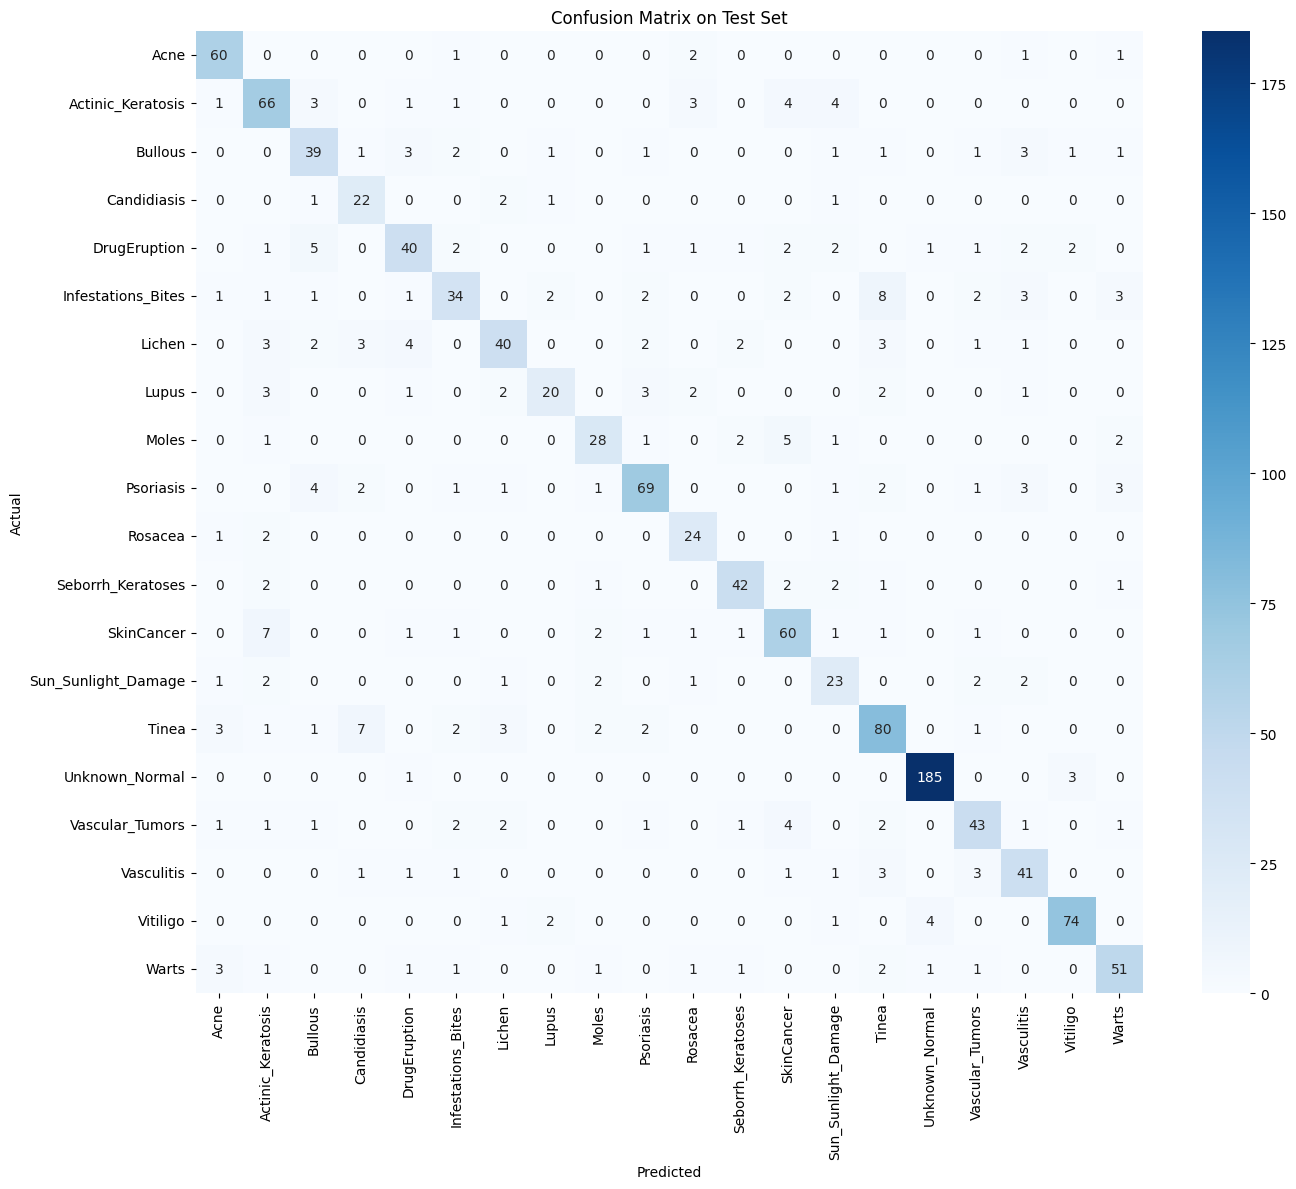

In [24]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = val_ds.classes

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 11. Prediction
This section demonstrates how to load a trained EfficientNet model and use it to predict the skin disease class for input image.


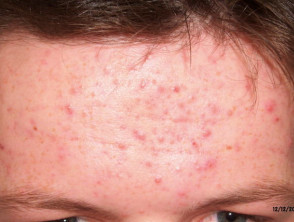

Prediction: Acne
Confidence: 100.00%


In [28]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image
from IPython.display import display
import os

# ------------------------------
# Image to predict
# ------------------------------
image_path = "/content/skindiseasedataset/SkinDisease/SkinDisease/test/Acne/acne-face-3-5__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDE4XQ.jpeg"  # Replace with image path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Class names
# ------------------------------
class_names = ['Acne', 'Actinic_Keratosis', 'Bullous', 'Candidiasis', 'DrugEruption',
               'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis',
               'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage',
               'Tinea', 'Unknown', 'Vascular_Tumors', 'Vasculitis',
               'Vitiligo', 'Warts']
NUM_CLASSES = len(class_names)

# ------------------------------
# Load model
# ------------------------------
model = EfficientNet.from_name("efficientnet-b0")
model._fc = torch.nn.Linear(model._fc.in_features, NUM_CLASSES)

# Load your trained model weights
state_dict = torch.load("/content/best_efficientnet.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# ------------------------------
# Image preprocessing
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ------------------------------
# Function to predict single image
# ------------------------------
def predict_single_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Preprocess and predict
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)

    prediction = class_names[pred.item()]
    confidence = confidence.item() * 100

    # Display image and prediction
    display(image)
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.2f}%")

predict_single_image(image_path)
